In [307]:
import numpy as np
import pandas as pd
import sklearn
import xgboost as xgb
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [308]:
df = pd.read_csv('../Данные/out_w_date_an_orig.csv', parse_dates=True)
df['add_time'] = pd.to_datetime(df['add_time'], format='%Y-%m-%d')
df['point_mean'] = df['point'].apply(lambda x: sum(map(int, x.split(',')))/len(x.split(',')))
df['point_sum'] = df['point'].apply(lambda x: sum(map(int, x.split(','))))
df = df[df['point_mean'] > 0].reset_index(drop=True)
df = df[(df['fintype_id'] == 1) & (df['eduform_id'] == 1)].reset_index(drop=True)

kcp = pd.read_csv('../Данные/kcp.csv', index_col=0)
kcp = kcp.drop(['index'], axis=1)
kcp = kcp.groupby(['name']).agg({'kcp': lambda x: x}).transpose()

In [309]:
pd.value_counts(df['eduform_id'], normalize=True)

1    1.0
Name: eduform_id, dtype: float64

In [310]:
pd.value_counts(df['fintype_id'], normalize=True)

1    1.0
Name: fintype_id, dtype: float64

In [311]:
pd.value_counts(df['status'], normalize=True)

1    0.626242
0    0.373758
Name: status, dtype: float64

In [312]:
pd.value_counts(df['true'], normalize=True)

0    0.850855
1    0.149145
Name: true, dtype: float64

In [313]:
df.head()

,abiturient_id,status,add_time,id,name,true,ex,point,eduform_id,fintype_id,point_mean,point_sum
0,202100622,1,2021-06-24,33,Проектирование авиационных и ракетных двигателей,0,"Математика,Физика,Русский язык","72,51,76",1,1,66.333333,199
1,202100622,1,2021-06-24,18,Ракетные комплексы и космонавтика,0,"Математика,Физика,Русский язык","72,51,76",1,1,66.333333,199
2,202100622,1,2021-06-24,32,"Проектирование, производство и эксплуатация ра...",0,"Математика,Физика,Русский язык","72,51,76",1,1,66.333333,199
3,202100622,1,2021-06-24,8,Лазерная техника и лазерные технологии,0,"Математика,Физика,Русский язык","72,51,76",1,1,66.333333,199
4,202100622,1,2021-06-24,6,Оптотехника,0,"Математика,Физика,Русский язык","72,51,76",1,1,66.333333,199


In [314]:
df.shape

(7248, 12)

In [315]:
pd.value_counts(df['true'], normalize=True)

0    0.850855
1    0.149145
Name: true, dtype: float64

In [316]:
gdf_mean = df.groupby(['name']).agg({'point_mean': ['mean'],
                                    }).transpose()
df['spec_mean_point'] = [gdf_mean[df.loc[i, ['name']][0]][0] for i in range(df.shape[0])]

In [317]:
df['bal_above_id'] = 0
df['bal_above_id_kcp'] = 0

for i in range(df.shape[0]):
    row = df.iloc[i]
    df.loc[i, ['bal_above_id']] = df[(df['name'] == row['name']) & (df['point_sum'] >= row['point_sum'])].shape[0]
    df.loc[i, ['bal_above_id_kcp']] = df[(df['name'] == row['name']) & (df['point_sum'] >= row['point_sum'])].shape[0]/kcp[row['name']][0]

In [318]:
df.head()

,abiturient_id,status,add_time,id,name,true,ex,point,eduform_id,fintype_id,point_mean,point_sum,spec_mean_point,bal_above_id,bal_above_id_kcp
0,202100622,1,2021-06-24,33,Проектирование авиационных и ракетных двигателей,0,"Математика,Физика,Русский язык","72,51,76",1,1,66.333333,199,67.647911,208,13.866667
1,202100622,1,2021-06-24,18,Ракетные комплексы и космонавтика,0,"Математика,Физика,Русский язык","72,51,76",1,1,66.333333,199,69.665808,266,3.325000
2,202100622,1,2021-06-24,32,"Проектирование, производство и эксплуатация ра...",0,"Математика,Физика,Русский язык","72,51,76",1,1,66.333333,199,69.914573,262,9.703704
3,202100622,1,2021-06-24,8,Лазерная техника и лазерные технологии,0,"Математика,Физика,Русский язык","72,51,76",1,1,66.333333,199,70.050562,129,6.142857
4,202100622,1,2021-06-24,6,Оптотехника,0,"Математика,Физика,Русский язык","72,51,76",1,1,66.333333,199,65.981352,60,6.000000


In [343]:
y = df['status']
X = df.drop(['abiturient_id', 'point_mean', 'add_time', 'eduform_id', 'fintype_id', 'point', 'id', 'status', 'true'], axis=1)

In [344]:
pd.value_counts(X['ex'])

Математика,Физика,Русский язык               4775
Математика,Информатика и ИКТ,Русский язык    2473
Name: ex, dtype: int64

In [345]:
pd.value_counts(X['name'])

Информационные системы и технологии                                                   615
Программная инженерия                                                                 600
Информатика и вычислительная техника                                                  589
Проектирование, производство и эксплуатация ракет и ракетно-космических комплексов    398
Проектирование авиационных и ракетных двигателей                                      391
Ракетные комплексы и космонавтика                                                     388
Боеприпасы и взрыватели                                                               309
Стрелково-пушечное, артиллерийское и ракетное оружие                                  285
Двигатели летательных аппаратов                                                       236
Мехатроника и робототехника                                                           229
Баллистика и гидроаэродинамика                                                        216
Навигацион

In [411]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from tensorflow.keras import layers
from tensorflow import keras

In [383]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=17)

In [384]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [385]:
X_train.head()

,name,ex,point_sum,spec_mean_point,bal_above_id,bal_above_id_kcp
0,Проектирование авиационных и ракетных двигателей,"Математика,Физика,Русский язык",243,67.647911,29,1.933333
1,Информатика и вычислительная техника,"Математика,Информатика и ИКТ,Русский язык",240,75.485003,260,6.842105
2,Информатика и вычислительная техника,"Математика,Информатика и ИКТ,Русский язык",166,75.485003,567,14.921053
3,Мехатроника и робототехника,"Математика,Физика,Русский язык",236,71.998544,55,2.500000
4,Боеприпасы и взрыватели,"Математика,Физика,Русский язык",240,63.639698,13,0.270833


In [386]:
pd.value_counts(X_train['ex'])

Математика,Физика,Русский язык               3225
Математика,Информатика и ИКТ,Русский язык    1631
Name: ex, dtype: int64

In [387]:
pd.value_counts(X_train['name'])

Информационные системы и технологии                                                   412
Программная инженерия                                                                 391
Информатика и вычислительная техника                                                  384
Проектирование авиационных и ракетных двигателей                                      268
Проектирование, производство и эксплуатация ракет и ракетно-космических комплексов    262
Ракетные комплексы и космонавтика                                                     260
Боеприпасы и взрыватели                                                               213
Стрелково-пушечное, артиллерийское и ракетное оружие                                  198
Двигатели летательных аппаратов                                                       157
Навигационно-баллистическое обеспечение применения космической техники                149
Радиотехника                                                                          146
Мехатроник

In [388]:
X_train['name'].nunique()

29

In [389]:
enc = OneHotEncoder(sparse=False)
cat_features = ['name', 'ex']
cat_df_train = []
cat_df_test = []
for cat in cat_features:
    encoded_train = pd.get_dummies(X_train[cat])
    encoded_test = pd.get_dummies(X_test[cat])
    cat_df_train.append(encoded_train)
    cat_df_test.append(encoded_test)

In [390]:
X_train_cat = pd.DataFrame(cat_df_train[0], columns=X_train['name'].unique()).join(pd.DataFrame(cat_df_train[-1], columns=X_train['ex'].unique()))
X_test_cat = pd.DataFrame(cat_df_test[0], columns=X_test['name'].unique()).join(pd.DataFrame(cat_df_test[-1], columns=X_test['ex'].unique()))

In [391]:
X_test_cat

,Специальные организационно-технические системы,Навигационно-баллистическое обеспечение применения космической техники,Информационные системы и технологии,Интегрированные системы летательных аппаратов,Информатика и вычислительная техника,Конструкторско-технологическое обеспечение машиностроительных производств,Прикладная механика,Радиоэлектронные системы и комплексы,Баллистика и гидроаэродинамика,Программная инженерия,...,Двигатели летательных аппаратов,"Стрелково-пушечное, артиллерийское и ракетное оружие",Боеприпасы и взрыватели,Стандартизация и метрология,Управление в технических системах,Мехатроника и робототехника,Фотоника и оптоинформатика,Лазерная техника и лазерные технологии,"Математика,Физика,Русский язык","Математика,Информатика и ИКТ,Русский язык"
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2387,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2388,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2389,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2390,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [392]:
X_test

,name,ex,point_sum,spec_mean_point,bal_above_id,bal_above_id_kcp
0,Специальные организационно-технические системы,"Математика,Физика,Русский язык",195,67.136752,66,4.714286
1,Навигационно-баллистическое обеспечение примен...,"Математика,Физика,Русский язык",163,66.359568,210,17.500000
2,Информационные системы и технологии,"Математика,Информатика и ИКТ,Русский язык",177,75.248780,561,14.025000
3,Интегрированные системы летательных аппаратов,"Математика,Информатика и ИКТ,Русский язык",249,74.476510,22,1.375000
4,Информатика и вычислительная техника,"Математика,Информатика и ИКТ,Русский язык",183,75.485003,531,13.973684
...,...,...,...,...,...,...
2387,Программная инженерия,"Математика,Информатика и ИКТ,Русский язык",194,76.076111,514,9.178571
2388,Технологические машины и оборудование,"Математика,Физика,Русский язык",186,62.908463,109,9.909091
2389,Информационные системы и технологии,"Математика,Информатика и ИКТ,Русский язык",220,75.248780,398,9.950000
2390,Радиотехника,"Математика,Информатика и ИКТ,Русский язык",161,72.305691,199,6.633333


In [393]:
X_train = X_train.join(X_train_cat).drop(['name', 'ex'], axis=1)
X_test = X_test.join(X_test_cat).drop(['name', 'ex'], axis=1)

In [394]:
X_test.head()

,point_sum,spec_mean_point,bal_above_id,bal_above_id_kcp,Специальные организационно-технические системы,Навигационно-баллистическое обеспечение применения космической техники,Информационные системы и технологии,Интегрированные системы летательных аппаратов,Информатика и вычислительная техника,Конструкторско-технологическое обеспечение машиностроительных производств,...,Двигатели летательных аппаратов,"Стрелково-пушечное, артиллерийское и ракетное оружие",Боеприпасы и взрыватели,Стандартизация и метрология,Управление в технических системах,Мехатроника и робототехника,Фотоника и оптоинформатика,Лазерная техника и лазерные технологии,"Математика,Физика,Русский язык","Математика,Информатика и ИКТ,Русский язык"
0,195,67.136752,66,4.714286,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,163,66.359568,210,17.500000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,177,75.248780,561,14.025000,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,249,74.476510,22,1.375000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,183,75.485003,531,13.973684,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [395]:
X_train.head()

,point_sum,spec_mean_point,bal_above_id,bal_above_id_kcp,Проектирование авиационных и ракетных двигателей,Информатика и вычислительная техника,Мехатроника и робототехника,Боеприпасы и взрыватели,Двигатели летательных аппаратов,Машиностроение,...,Специальные организационно-технические системы,Оптотехника,Навигационно-баллистическое обеспечение применения космической техники,Системы управления летательными аппаратами,Фотоника и оптоинформатика,Радиоэлектронные системы и комплексы,Интегрированные системы летательных аппаратов,Радиотехника,"Математика,Физика,Русский язык","Математика,Информатика и ИКТ,Русский язык"
0,243,67.647911,29,1.933333,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,240,75.485003,260,6.842105,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,166,75.485003,567,14.921053,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,236,71.998544,55,2.500000,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,240,63.639698,13,0.270833,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [396]:
scaler = RobustScaler()
num_vars = ['point_sum', 'spec_mean_point', 'bal_above_id', 'bal_above_id_kcp']
X_train.loc[:, num_vars] = scaler.fit_transform(X_train.loc[:, num_vars])
X_test.loc[:, num_vars] = scaler.transform(X_test.loc[:, num_vars])

In [397]:
scaler.scale_

array([ 41.        ,   8.60339042, 159.        ,   7.03571429])

In [398]:
X_train.head()

,point_sum,spec_mean_point,bal_above_id,bal_above_id_kcp,Проектирование авиационных и ракетных двигателей,Информатика и вычислительная техника,Мехатроника и робототехника,Боеприпасы и взрыватели,Двигатели летательных аппаратов,Машиностроение,...,Специальные организационно-технические системы,Оптотехника,Навигационно-баллистическое обеспечение применения космической техники,Системы управления летательными аппаратами,Фотоника и оптоинформатика,Радиоэлектронные системы и комплексы,Интегрированные системы летательных аппаратов,Радиотехника,"Математика,Физика,Русский язык","Математика,Информатика и ИКТ,Русский язык"
0,0.829268,-0.146780,-0.635220,-0.563120,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.756098,0.764151,0.817610,0.134573,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-1.048780,0.764151,2.748428,1.282850,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.658537,0.358909,-0.471698,-0.482579,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0.756098,-0.612667,-0.735849,-0.799414,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


Препроцессинг закончили, начинаем обучать

In [399]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
input_shape = X_train.shape[1]

In [ ]:
1    0.626242
0    0.373758

In [446]:
model = keras.Sequential([
    layers.Dense(100, activation='relu', input_shape=(input_shape,)),
    layers.Dense(120, activation='relu', kernel_regularizer='l2'),
    layers.GaussianDropout(rate=0.4),
    layers.Dense(70, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.GaussianNoise(0.1),
    layers.Dense(25, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [447]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['Precision', 'Recall', 'AUC']
)

In [448]:
model.fit(X_train, y_train.to_numpy(), batch_size=32, epochs=100, class_weight={0:0.37, 1:0.62})

Epoch 1/100
152/152 [==============================] - 1s 1ms/step - loss: 0.6472 - precision: 0.6344 - recall: 0.9813 - auc: 0.6465
Epoch 2/100
152/152 [==============================] - 0s 1ms/step - loss: 0.2953 - precision: 0.6558 - recall: 0.9624 - auc: 0.7086
Epoch 3/100
152/152 [==============================] - 0s 1ms/step - loss: 0.2806 - precision: 0.6578 - recall: 0.9594 - auc: 0.7099
Epoch 4/100
152/152 [==============================] - 0s 1ms/step - loss: 0.2778 - precision: 0.6618 - recall: 0.9493 - auc: 0.7150
Epoch 5/100
152/152 [==============================] - 0s 1ms/step - loss: 0.2774 - precision: 0.6601 - recall: 0.9391 - auc: 0.7136
Epoch 6/100
152/152 [==============================] - 0s 1ms/step - loss: 0.2743 - precision: 0.6579 - recall: 0.9581 - auc: 0.7214
Epoch 7/100
152/152 [==============================] - 0s 1ms/step - loss: 0.2751 - precision: 0.6611 - recall: 0.9489 - auc: 0.7210
Epoch 8/100
152/152 [==============================] - 0s 1ms/step - 

152/152 [==============================] - 0s 1ms/step - loss: 0.2654 - precision: 0.6646 - recall: 0.9686 - auc: 0.7387
Epoch 63/100
152/152 [==============================] - 0s 1ms/step - loss: 0.2654 - precision: 0.6609 - recall: 0.9715 - auc: 0.7408
Epoch 64/100
152/152 [==============================] - 0s 1ms/step - loss: 0.2661 - precision: 0.6642 - recall: 0.9679 - auc: 0.7361
Epoch 65/100
152/152 [==============================] - 0s 1ms/step - loss: 0.2651 - precision: 0.6582 - recall: 0.9725 - auc: 0.7427
Epoch 66/100
152/152 [==============================] - 0s 1ms/step - loss: 0.2655 - precision: 0.6579 - recall: 0.9692 - auc: 0.7416
Epoch 67/100
152/152 [==============================] - 0s 1ms/step - loss: 0.2658 - precision: 0.6649 - recall: 0.9607 - auc: 0.7396
Epoch 68/100
152/152 [==============================] - 0s 1ms/step - loss: 0.2664 - precision: 0.6602 - recall: 0.9748 - auc: 0.7357
Epoch 69/100
152/152 [==============================] - 0s 1ms/step - loss:

In [449]:
model.evaluate(X_test, y_test.to_numpy())

75/75 [==============================] - 0s 689us/step - loss: 0.6590 - precision: 0.6452 - recall: 0.9609 - auc: 0.6850


[0.6590234637260437,
 0.6452488899230957,
 0.9609164595603943,
 0.6850447058677673]

In [450]:
y_pred = model.predict(X_test) > 0.5

In [451]:
cnf_mt = confusion_matrix(y_test, y_pred)

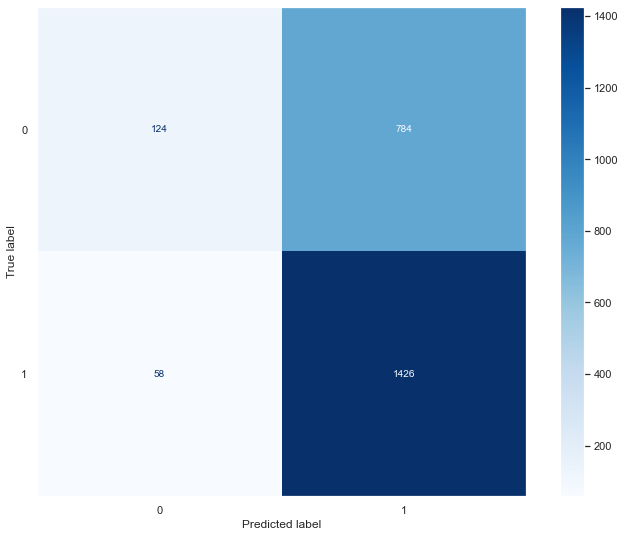

In [452]:
fig, ax = plt.subplots()
fig.set_size_inches((12, 9))
disp = ConfusionMatrixDisplay(cnf_mt)
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.grid(False)